In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder


In [2]:
# @title Access Google Drive
# Mount to access via file system

from google.colab import drive

drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "" # specify path to data folder in Google Drive

# Preprocessing 1

In [4]:
motor_vehicle_crashes = pd.read_csv(
    path + "motor_vehicle_crashes.csv", low_memory=False
)


In [5]:
motor_vehicle_crashes.shape

(1985365, 29)

In [6]:
motor_vehicle_crashes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985365 entries, 0 to 1985364
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

In [8]:
# convert crash date and time to datetime format
df["CRASH DATE"] = pd.to_datetime(df["CRASH DATE"], format="%m/%d/%Y")
df["CRASH TIME"] = pd.to_datetime(df["CRASH TIME"], format="%H:%M")

# create month and hour columns
# df['YEAR'] = df['CRASH DATE'].dt.year
df["MONTH"] = df["CRASH DATE"].dt.month
df["HOUR"] = df["CRASH TIME"].dt.hour

# sort the DataFrame by time
df = df.sort_values(["CRASH DATE", "CRASH TIME"])


In [9]:
weather = pd.read_csv(path + "NYC_Daily_Weather.csv")
weather_features = ["datetime", "tempmin", "precip", "windspeed", "visibility", "icon"]
weather = weather[weather_features]

weather.rename(columns={"datetime": "CRASH DATE"}, inplace=True)
weather["CRASH DATE"] = pd.to_datetime(weather["CRASH DATE"], format="%Y/%m/%d")


In [10]:
df_merged = pd.merge(df, weather, on="CRASH DATE")

df_merged = df_merged.groupby("CRASH DATE").ffill()

df_merged = df_merged.reset_index(drop=True)


In [11]:
df = df_merged
df.drop(["CRASH TIME"], axis=1, inplace=True)


In [12]:
# location
df.drop(
    [
        "BOROUGH",
        "ZIP CODE",
        "LOCATION",
        "ON STREET NAME",
        "CROSS STREET NAME",
        "OFF STREET NAME",
    ],
    axis=1,
    inplace=True,
)

df = df[df["LATITUDE"].notna()]
df = df[df["LONGITUDE"].notna()]

maxLat = df["LATITUDE"].max()
minLat = df["LATITUDE"].min()
maxLong = df["LONGITUDE"].max()
minLong = df["LONGITUDE"].min()
# normalize the 'LATITUDE' and 'LONGITUDE' columns to be between 0 and 1
df["LATITUDE"] = df["LATITUDE"].apply(lambda x: (x - minLat) / (maxLat - minLat))
df["LONGITUDE"] = df["LONGITUDE"].apply(lambda x: (x - minLong) / (maxLong - minLong))


In [13]:
df["INJURED/KILLED"] = (
    df["NUMBER OF PERSONS INJURED"]
    + df["NUMBER OF PERSONS KILLED"]
    + df["NUMBER OF PEDESTRIANS INJURED"]
    + df["NUMBER OF PEDESTRIANS KILLED"]
    + df["NUMBER OF CYCLIST INJURED"]
    + df["NUMBER OF CYCLIST KILLED"]
    + df["NUMBER OF MOTORIST INJURED"]
    + df["NUMBER OF MOTORIST KILLED"]
)

df["INJURED/KILLED"] = np.where(df["INJURED/KILLED"] == 0, 0, 1)

df.drop(
    [
        "NUMBER OF PERSONS INJURED",
        "NUMBER OF PERSONS KILLED",
        "NUMBER OF PEDESTRIANS INJURED",
        "NUMBER OF PEDESTRIANS KILLED",
        "NUMBER OF CYCLIST INJURED",
        "NUMBER OF CYCLIST KILLED",
        "NUMBER OF MOTORIST INJURED",
        "NUMBER OF MOTORIST KILLED",
    ],
    axis=1,
    inplace=True,
)


In [14]:
df.drop(
    [
        "CONTRIBUTING FACTOR VEHICLE 1",
        "CONTRIBUTING FACTOR VEHICLE 2",
        "CONTRIBUTING FACTOR VEHICLE 3",
        "CONTRIBUTING FACTOR VEHICLE 4",
        "CONTRIBUTING FACTOR VEHICLE 5",
        "VEHICLE TYPE CODE 2",
        "VEHICLE TYPE CODE 3",
        "VEHICLE TYPE CODE 4",
        "VEHICLE TYPE CODE 5",
    ],
    axis=1,
    inplace=True,
)


In [15]:
df.drop(["COLLISION_ID"], axis=1, inplace=True)
df = df.dropna()


In [16]:
print(df[df["INJURED/KILLED"] == 0].shape)
print(df[df["INJURED/KILLED"] == 1].shape)


(1479891, 11)
(421475, 11)


In [17]:
thresh = int(0.02 * df.shape[0])
df["VEHICLE TYPE CODE 1"].replace(
    df["VEHICLE TYPE CODE 1"]
    .value_counts()[df["VEHICLE TYPE CODE 1"].value_counts() < thresh]
    .index,
    "OTHER",
    inplace=True,
)


In [18]:
df["VEHICLE TYPE CODE 1"].unique()


array(['OTHER', 'SPORT UTILITY / STATION WAGON', 'PASSENGER VEHICLE',
       'Sedan', 'Taxi', 'Station Wagon/Sport Utility Vehicle',
       '4 dr sedan'], dtype=object)

In [33]:
df = df.reset_index(drop=True)


In [34]:
# df.to_csv(path + 'data_cleaned_new.csv')
df


,LATITUDE,LONGITUDE,VEHICLE TYPE CODE 1,MONTH,HOUR,tempmin,precip,windspeed,visibility,icon,INJURED/KILLED
0,0.939528,0.632484,OTHER,12,0,2.4,0.0,23.2,13.6,cloudy,0
1,0.940310,0.632550,OTHER,12,0,2.4,0.0,23.2,13.6,cloudy,0
2,0.938605,0.632717,SPORT UTILITY / STATION WAGON,12,0,2.4,0.0,23.2,13.6,cloudy,0
3,0.939961,0.632574,OTHER,12,0,2.4,0.0,23.2,13.6,cloudy,0
4,0.939412,0.632562,SPORT UTILITY / STATION WAGON,12,0,2.4,0.0,23.2,13.6,cloudy,0
...,...,...,...,...,...,...,...,...,...,...,...
1901361,0.939474,0.632721,OTHER,4,23,8.5,0.0,29.5,16.0,partly-cloudy-day,0
1901362,0.936409,0.632669,Sedan,4,23,8.5,0.0,29.5,16.0,partly-cloudy-day,0
1901363,0.941070,0.633455,Sedan,4,23,8.5,0.0,29.5,16.0,partly-cloudy-day,0
1901364,0.939886,0.633423,Sedan,4,23,8.5,0.0,29.5,16.0,partly-cloudy-day,0


# Plots

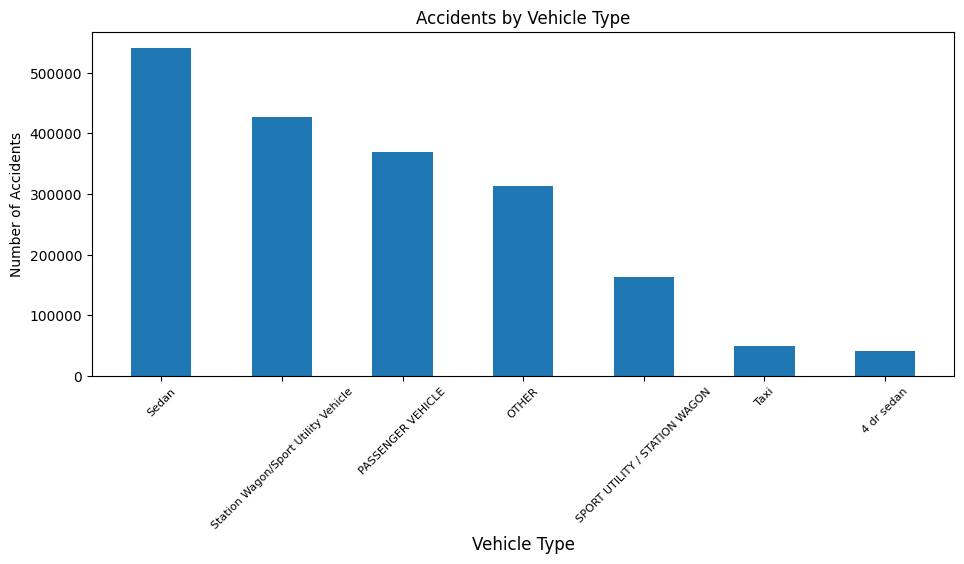

In [14]:
vehicle_counts = df["VEHICLE TYPE CODE 1"].value_counts()

# Create the figure with custom size
plt.figure(figsize=(10, 6))

# Create the bar chart with customizations
plt.bar(vehicle_counts.index, vehicle_counts.values, width=0.5)
plt.xlabel("Vehicle Type", fontsize=12)
plt.ylabel("Number of Accidents")
plt.title("Accidents by Vehicle Type")

# Rotate the x-ticks by 45 degrees and increase their font size
plt.xticks(rotation=45, fontsize=8)

# Adjust the spacing between subplots to make the x-axis wider
plt.tight_layout(pad=2)

plt.show()


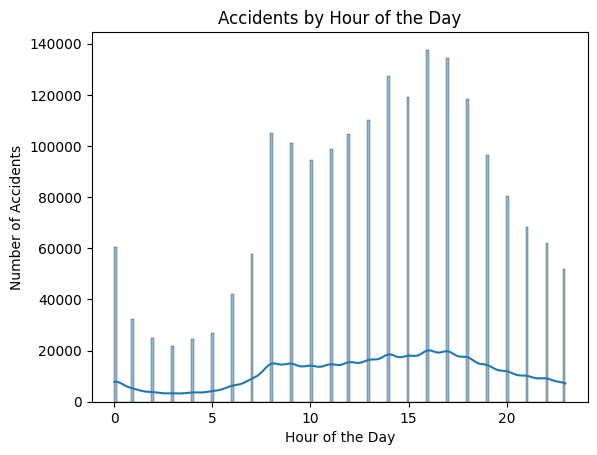

In [40]:
sns.histplot(df["HOUR"], kde=True, kde_kws={"bw_adjust": 1.5})

plt.xlabel("Hour of the Day")
plt.ylabel("Number of Accidents")
plt.title("Accidents by Hour of the Day")

plt.show()


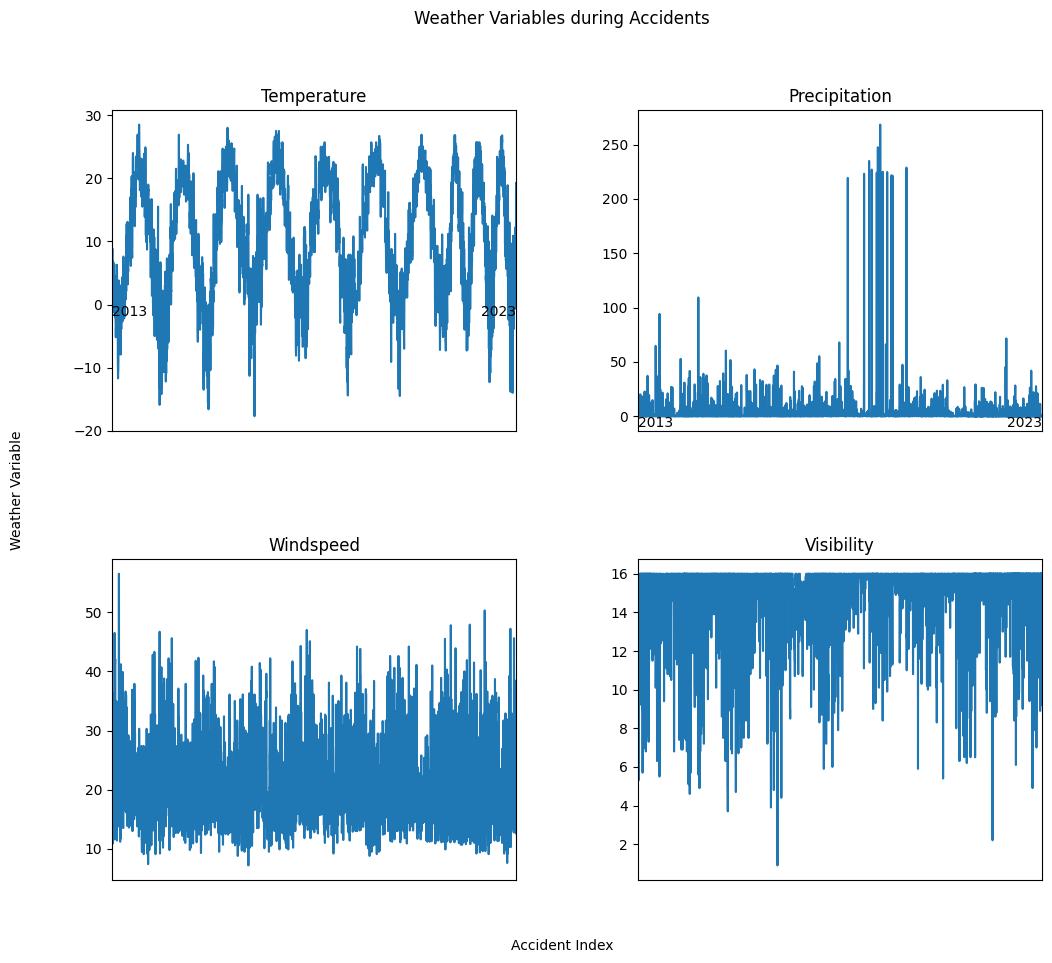

In [18]:
# Create a 2x2 grid of subplots with a larger figure size
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot temperature in the top-left subplot
axs[0, 0].plot(df["tempmin"])
axs[0, 0].set_title("Temperature")
axs[0, 0].set_xticks([])
axs[0, 0].set_xlim(df.index.min(), df.index.max())
axs[0, 0].annotate("2013", xy=(df.index.min(), -0.1), ha="left", va="top")
axs[0, 0].annotate("2023", xy=(df.index.max(), -0.1), ha="right", va="top")

# Plot precipitation in the top-right subplot
axs[0, 1].plot(df["precip"])
axs[0, 1].set_title("Precipitation")
axs[0, 1].set_xticks([])
axs[0, 1].set_xlim(df.index.min(), df.index.max())
axs[0, 1].annotate("2013", xy=(df.index.min(), -0.1), ha="left", va="top")
axs[0, 1].annotate("2023", xy=(df.index.max(), -0.1), ha="right", va="top")

# Plot windspeed in the bottom-left subplot
axs[1, 0].plot(df["windspeed"])
axs[1, 0].set_title("Windspeed")
axs[1, 0].set_xticks([])
axs[1, 0].set_xlim(df.index.min(), df.index.max())
axs[1, 0].annotate("2013", xy=(df.index.min(), -0.1), ha="left", va="top")
axs[1, 0].annotate("2023", xy=(df.index.max(), -0.1), ha="right", va="top")

# Plot visibility in the bottom-right subplot
axs[1, 1].plot(df["visibility"])
axs[1, 1].set_title("Visibility")
axs[1, 1].set_xticks([])
axs[1, 1].set_xlim(df.index.min(), df.index.max())
axs[1, 1].annotate("2013", xy=(df.index.min(), -0.1), ha="left", va="top")
axs[1, 1].annotate("2023", xy=(df.index.max(), -0.1), ha="right", va="top")

# Add a shared x-label and y-label
fig.text(0.5, 0.04, "Accident Index", ha="center")
fig.text(0.04, 0.5, "Weather Variable", va="center", rotation="vertical")

# Add a title for the whole figure
fig.suptitle("Weather Variables during Accidents")

# Adjust the padding between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.3)

plt.show()


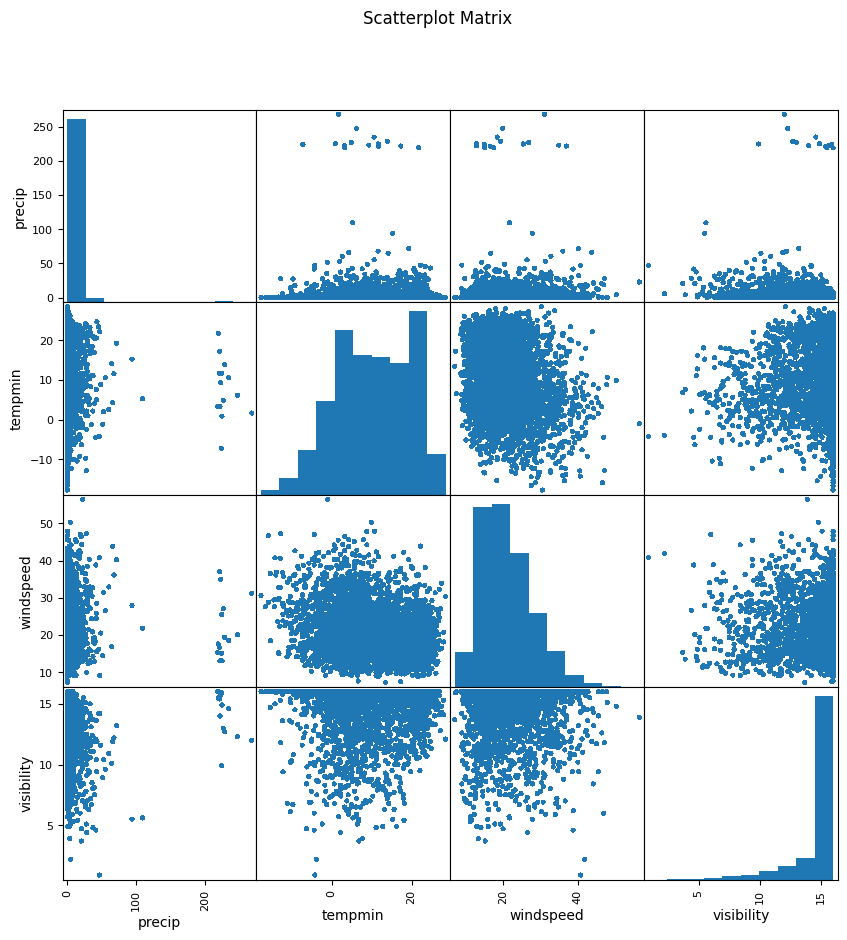

In [48]:
from pandas.plotting import scatter_matrix

scatter_matrix(df[["precip", "tempmin", "windspeed", "visibility"]], figsize=(10, 10))
plt.suptitle("Scatterplot Matrix")
plt.show()


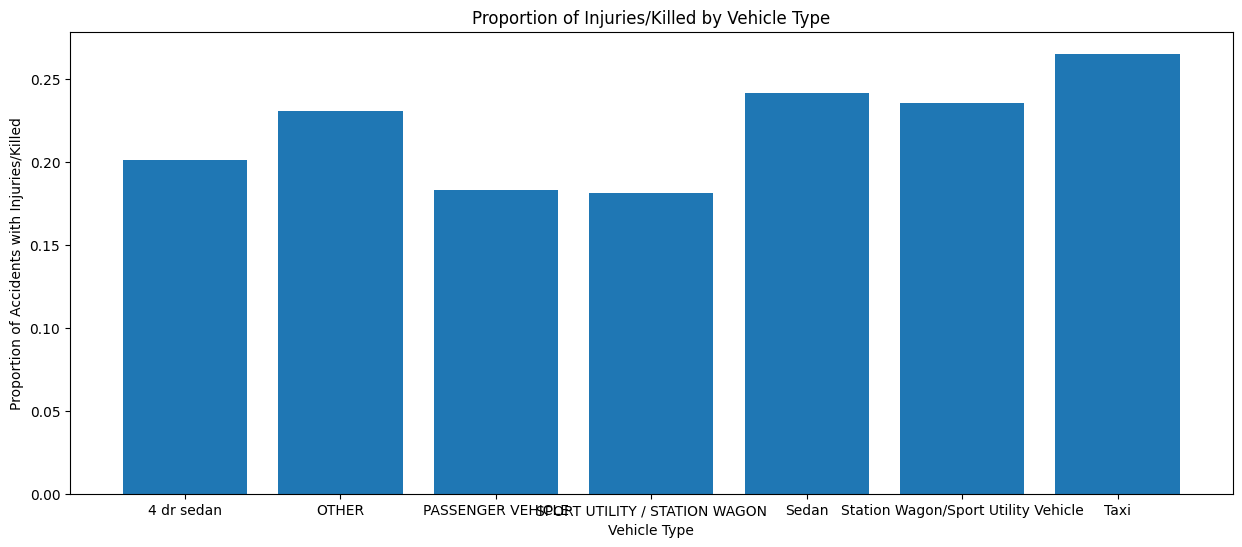

In [46]:
# Calculate the proportion of accidents with INJURED/KILLED=1 for each unique value of the 'VEHICLE TYPE CODE 1' variable
prop_injured = df.groupby("VEHICLE TYPE CODE 1")["INJURED/KILLED"].mean()

# Plot the proportion of accidents with INJURED/KILLED=1 for each unique value of the 'VEHICLE TYPE CODE 1' variable
fig, ax = plt.subplots(figsize=(15, 6))  # set a wider figure size
ax.bar(prop_injured.index, prop_injured.values)
ax.set_xlabel("Vehicle Type")
ax.set_ylabel("Proportion of Accidents with Injuries/Killed")
ax.set_title("Proportion of Injuries/Killed by Vehicle Type")
plt.show()


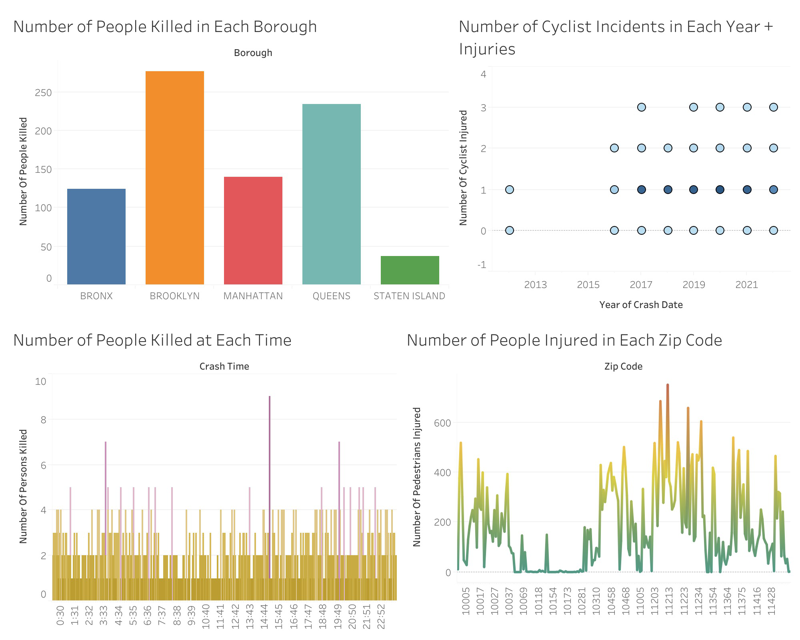

In [76]:
from PIL import Image

image = Image.open("Dashboard.jpg")

width, height = image.size
aspect_ratio = height / width
new_width = 800
new_height = int(new_width * aspect_ratio)
resized_image = image.resize((new_width, new_height))

# Show the resized image
resized_image.show()


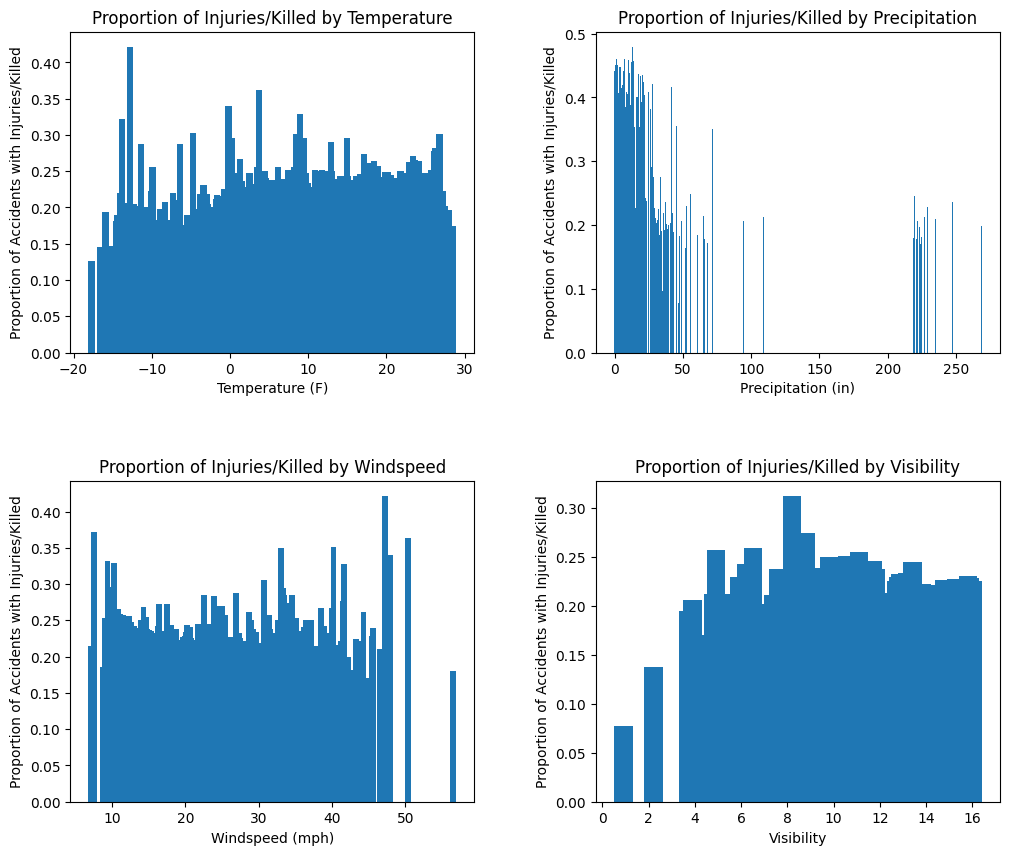

In [47]:
# Group the dataframe by each of the four weather variables and calculate the proportion of accidents with INJURED/KILLED=1 for each unique value
prop_injured_tempmin = df.groupby("tempmin")["INJURED/KILLED"].mean()
prop_injured_precip = df.groupby("precip")["INJURED/KILLED"].mean()
prop_injured_windspeed = df.groupby("windspeed")["INJURED/KILLED"].mean()
prop_injured_visibility = df.groupby("visibility")["INJURED/KILLED"].mean()

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot the proportion of accidents with INJURED/KILLED=1 for each unique value of 'tempmin' in the top-left subplot
axs[0, 0].bar(prop_injured_tempmin.index, prop_injured_tempmin.values)
axs[0, 0].set_xlabel("Temperature (F)")
axs[0, 0].set_ylabel("Proportion of Accidents with Injuries/Killed")
axs[0, 0].set_title("Proportion of Injuries/Killed by Temperature")

# Plot the proportion of accidents with INJURED/KILLED=1 for each unique value of 'precip' in the top-right subplot
axs[0, 1].bar(prop_injured_precip.index, prop_injured_precip.values)
axs[0, 1].set_xlabel("Precipitation (in)")
axs[0, 1].set_ylabel("Proportion of Accidents with Injuries/Killed")
axs[0, 1].set_title("Proportion of Injuries/Killed by Precipitation")

# Plot the proportion of accidents with INJURED/KILLED=1 for each unique value of 'windspeed' in the bottom-left subplot
axs[1, 0].bar(prop_injured_windspeed.index, prop_injured_windspeed.values)
axs[1, 0].set_xlabel("Windspeed (mph)")
axs[1, 0].set_ylabel("Proportion of Accidents with Injuries/Killed")
axs[1, 0].set_title("Proportion of Injuries/Killed by Windspeed")

# Plot the proportion of accidents with INJURED/KILLED=1 for each unique value of 'visibility' in the bottom-right subplot
axs[1, 1].bar(prop_injured_visibility.index, prop_injured_visibility.values)
axs[1, 1].set_xlabel("Visibility")
axs[1, 1].set_ylabel("Proportion of Accidents with Injuries/Killed")
axs[1, 1].set_title("Proportion of Injuries/Killed by Visibility")

# Adjust the padding between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.3)

plt.show()


# Preprocessing 2

In [49]:
data_clean_path = (
    "/content/drive/Othercomputers/MacBook Air 2021/Desktop/cubist/data_cleaned_new.csv"
)
# data_clean = pd.read_csv(data_clean_path)
# df = data_clean
data_clean = df


In [51]:
data_clean.head()


,LATITUDE,LONGITUDE,VEHICLE TYPE CODE 1,MONTH,HOUR,tempmin,precip,windspeed,visibility,icon,INJURED/KILLED
0,0.939528,0.632484,OTHER,12,0,2.4,0.0,23.2,13.6,cloudy,0
1,0.940310,0.632550,OTHER,12,0,2.4,0.0,23.2,13.6,cloudy,0
2,0.938605,0.632717,SPORT UTILITY / STATION WAGON,12,0,2.4,0.0,23.2,13.6,cloudy,0
3,0.939961,0.632574,OTHER,12,0,2.4,0.0,23.2,13.6,cloudy,0
4,0.939412,0.632562,SPORT UTILITY / STATION WAGON,12,0,2.4,0.0,23.2,13.6,cloudy,0


In [53]:
data_clean.columns


Index(['LATITUDE', 'LONGITUDE', 'VEHICLE TYPE CODE 1', 'MONTH', 'HOUR',
       'tempmin', 'precip', 'windspeed', 'visibility', 'icon',
       'INJURED/KILLED'],
      dtype='object')

In [52]:
data_clean.shape


(1901366, 11)

In [54]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [55]:
# Rename data into X,y notation
X = data_clean.drop("INJURED/KILLED", axis=1)
y = data_clean["INJURED/KILLED"]

# Partition using 80/20 split, as specified above
# (noting that the train set is currently both the train and validation sets)
X_train_v, X_test, y_train_v, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


categorical_cols = ["VEHICLE TYPE CODE 1", "icon"]
# categorical_cols = ['VEHICLE TYPE CODE 1']

numerical_cols = [
    "LATITUDE",
    "LONGITUDE",
    "MONTH",
    "HOUR",
    "tempmin",
    "precip",
    "windspeed",
    "visibility",
]
# numerical_cols = ['LATITUDE', 'LONGITUDE', 'MONTH', 'HOUR']

target = "INJURED/KILLED"


In [56]:
# Get only numerical features
X_train_v_num = X_train_v.drop(categorical_cols, axis=1)
X_test_num = X_test.drop(categorical_cols, axis=1)

"""
# Impute numerical values
imputer = SimpleImputer( strategy = 'median')

# Fit and transform for the train set
X_train_v_num = imputer.fit_transform(X_train_v_num);

# Only transform for test set
X_test_num = imputer.transform(X_test_num)
"""

# Scale and normalize numerical features using MinMaxScaler
min_max_scaler = MinMaxScaler()

# Fit and transform for the train set
X_train_v_min_max = min_max_scaler.fit_transform(X_train_v_num)

# Only transform for test set
X_test_min_max = min_max_scaler.transform(X_test_num)


In [57]:
# Handle categorical variable (ocean proximity)
X_train_v_cat = X_train_v[categorical_cols]
X_test_cat = X_test[categorical_cols]

# We use one-hot-encoding
cat_encoder = OneHotEncoder(sparse=False)

# Fit and transform for the train set
X_train_v_1hot = cat_encoder.fit_transform(X_train_v_cat)

# Only transform for test set
X_test_1hot = cat_encoder.transform(X_test_cat)


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [58]:
# Concatenate preprocessed numerical and categorical data
X_train_v = np.concatenate((X_train_v_min_max, X_train_v_1hot), axis=1)
X_test = np.concatenate((X_test_min_max, X_test_1hot), axis=1)


# PCA

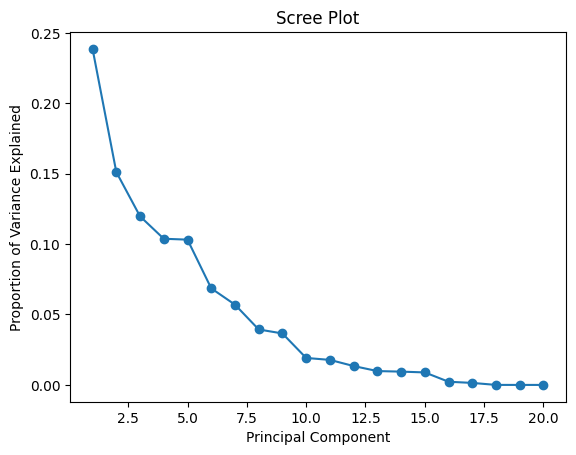

In [60]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA to the data
pca = PCA()
X_pca = pca.fit_transform(X_train_v)

# Calculate the proportion of variance explained by each component
var_exp = pca.explained_variance_ratio_

# Create a scree plot
fig, ax = plt.subplots()
ax.plot(range(1, len(var_exp) + 1), var_exp, marker="o")
ax.set_xlabel("Principal Component")
ax.set_ylabel("Proportion of Variance Explained")
ax.set_title("Scree Plot")
plt.show()


In [14]:
# Get explained variance ratio of each principal component
variance_ratios = pca.explained_variance_ratio_

# Sort variance ratios in descending order and get the corresponding indices
sorted_indices = np.argsort(variance_ratios)[::-1]

# Print top 3 principal components and their variance ratio
for i in range(3):
    pc_index = sorted_indices[i]
    pc_variance_ratio = variance_ratios[pc_index]
    print(
        f"Principal Component {i+1}: {pc_variance_ratio*100:.2f}% variation explained"
    )


Principal Component 1: 23.86% variation explained
Principal Component 2: 15.11% variation explained
Principal Component 3: 11.97% variation explained


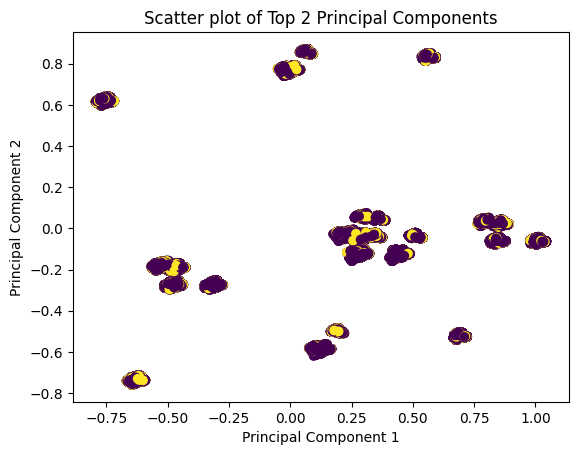

In [15]:
# select the top 2 principal components
top_2_pc = X_pca[:, :2]

# create a scatter plot of the top 2 principal components, colored by the target variable
plt.scatter(top_2_pc[:, 0], top_2_pc[:, 1], c=y_train_v)

# add axis labels and a title
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Scatter plot of Top 2 Principal Components")
plt.show()


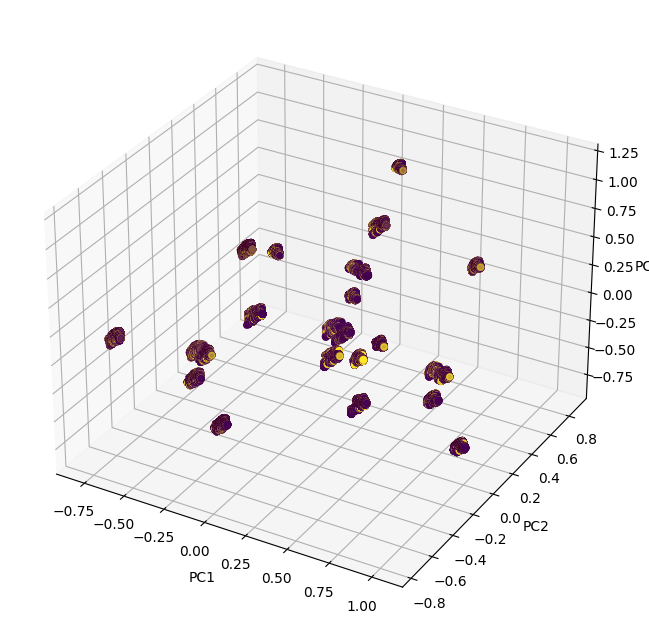

In [18]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_train_v)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()


In [61]:
# Get the top 10 principal components
X_train_pca = X_pca[:, :10]
X_test_pca = pca.transform(X_test)
X_test_pca = X_test_pca[:, :10]


# K nearest neighbours

In [20]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

X_train_r = X_train_v[-10000:]
y_train_v_r = y_train_v[-10000:]

X_test_r = X_test[:2000]
y_test_r = y_test[:2000]

# Initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model on the training data
knn.fit(X_train_r, y_train_v_r)

# Make predictions on the test set
y_pred = knn.predict(X_test_r)

# Evaluate model performance
accuracy = accuracy_score(y_test_r, y_pred)
f1 = f1_score(y_test_r, y_pred, average="weighted")
conf_mat = confusion_matrix(y_test_r, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
# print('Confusion Matrix:\n', conf_mat)


Accuracy: 0.727
F1 Score: 0.6784203062354854


In [22]:
# @title K nearest neighbours with PCA
knn = KNeighborsClassifier(n_neighbors=5)

X_train_pca_r = X_train_pca[-10000:]
y_train_v_r = y_train_v[-10000:]

X_test_pca_r = X_test_pca[:2000]
y_test_r = y_test[:2000]

# Train the model on the training data
knn.fit(X_train_pca_r, y_train_v_r)

# Make predictions on the test set
y_pred = knn.predict(X_test_pca_r)

# Evaluate model performance
accuracy = accuracy_score(y_test_r, y_pred)
f1 = f1_score(y_test_r, y_pred, average="weighted")
conf_mat = confusion_matrix(y_test_r, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
# print('Confusion Matrix:\n', conf_mat)


Accuracy: 0.723
F1 Score: 0.6748064351902789


# XGBoost

In [30]:
neg_to_pos_ratio = (y_train_v == 0).sum() / (y_train_v == 1).sum()
scale_pos_weight = neg_to_pos_ratio


import xgboost as xgb

# Create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train_v, label=y_train_v)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost hyperparameters
params = {
    "max_depth": 7,
    "learning_rate": 0.2,
    "objective": "binary:logistic",
    "scale_pos_weight": scale_pos_weight,
}

# Train XGBoost model
model = xgb.train(params, dtrain)

# Make predictions on the test set
y_pred_proba = model.predict(dtest)  # predicted probabilities
y_pred = (y_pred_proba > 0.5).astype(int)  # predicted class labels

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
conf_mat = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics and predicted probabilities
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_mat)


Accuracy: 0.5574638287129806
F1 Score: 0.5948519981201001
Confusion Matrix:
 [[162397 133530]
 [ 34755  49592]]


In [31]:
# @title XGBoost with PCA
# Create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train_pca, label=y_train_v)
dtest = xgb.DMatrix(X_test_pca, label=y_test)

# Define XGBoost hyperparameters
params = {
    "max_depth": 7,
    "learning_rate": 0.2,
    "objective": "binary:logistic",
    "scale_pos_weight": scale_pos_weight,
}

# Train XGBoost model
model = xgb.train(params, dtrain)

# Make predictions on the test set
y_pred_proba = model.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)
conf_mat = confusion_matrix(y_test, y_pred)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

# Print the evaluation metrics
print("Accuracy (PCA):", accuracy)
print("F1 Score (PCA):", f1)
print("Confusion Matrix:\n", conf_mat)


Accuracy (PCA): 0.5476761493028711
F1 Score (PCA): 0.5858788412457854
Confusion Matrix:
 [[160214 135713]
 [ 36294  48053]]


# SVC

In [20]:
# @title SVC with PCA

from sklearn.svm import SVC

# Define SVM hyperparameters
params = {"C": 1.0, "kernel": "rbf", "gamma": "scale", "class_weight": "balanced"}

X_train_pca_r = X_train_pca[-10000:]
y_train_v_r = y_train_v[-10000:]

X_test_pca_r = X_test_pca[:2000]
y_test_r = y_test[:2000]

# Train SVM model
model = SVC(**params)
model.fit(X_train_pca_r, y_train_v_r)

# Make predictions on the test set
y_pred = model.predict(X_test_pca_r)

# Evaluate model performance
accuracy = accuracy_score(y_test_r, y_pred)
f1 = f1_score(y_test_r, y_pred, average="weighted")

# Print the evaluation metrics
print("Accuracy (PCA):", accuracy)
print("F1 Score (PCA):", f1)


Accuracy (PCA): 0.5005
F1 Score (PCA): 0.5373506921944035


# Neural Network

In [62]:
print(X_train_v.shape)
print(X_test.shape)


(1521092, 20)
(380274, 20)


In [63]:
# calculate the index to split the DataFrame
split_index = int(0.8 * len(X_train_v))

# Split into train and test sets based on split index
X_train = X_train_v[:split_index]
X_valid = X_train_v[split_index:]

y_train = y_train_v[:split_index]
y_valid = y_train_v[split_index:]


In [64]:
from imblearn.over_sampling import SMOTE

# Define the SMOTE strategy
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [65]:
# Ensure data is clean
assert not np.any(np.isnan(X_train))


In [66]:
X_train_resampled.shape


(1894366, 20)

In [67]:
# tf imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Dense,
    LeakyReLU,
    BatchNormalization,
    AlphaDropout,
)

from tensorflow.keras.initializers import he_normal, lecun_normal

from tensorflow.keras.optimizers import SGD, Adam, Adamax, Nadam, RMSprop
from tensorflow.keras.optimizers.experimental import AdamW

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [68]:
# Model architecuture setup
model = Sequential()

# input layer
model.add(Input(shape=[X_train.shape[1]]))

# hidden layers
model.add(Dense(units=128, activation="selu", kernel_initializer="lecun_normal"))
model.add(Dense(units=128, activation="selu", kernel_initializer="lecun_normal"))
model.add(Dense(units=128, activation="selu", kernel_initializer="lecun_normal"))
model.add(Dense(units=128, activation="selu", kernel_initializer="lecun_normal"))
model.add(Dense(units=128, activation="selu", kernel_initializer="lecun_normal"))
model.add(Dense(units=128, activation="selu", kernel_initializer="lecun_normal"))
model.add(Dense(units=128, activation="selu", kernel_initializer="lecun_normal"))
model.add(Dense(units=128, activation="selu", kernel_initializer="lecun_normal"))

model.add(Dense(units=128, activation="selu", kernel_initializer="lecun_normal"))
model.add(Dense(units=128, activation="selu", kernel_initializer="lecun_normal"))
model.add(Dense(units=128, activation="selu", kernel_initializer="lecun_normal"))
model.add(Dense(units=128, activation="selu", kernel_initializer="lecun_normal"))
model.add(Dense(units=128, activation="selu", kernel_initializer="lecun_normal"))
model.add(Dense(units=128, activation="selu", kernel_initializer="lecun_normal"))
model.add(Dense(units=128, activation="selu", kernel_initializer="lecun_normal"))
model.add(Dense(units=128, activation="selu", kernel_initializer="lecun_normal"))
# output layer
model.add(Dense(units=1, activation="sigmoid"))

opt = SGD(momentum=0.9, nesterov=True, clipnorm=1.0)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


In [69]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2688      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 128)               1

In [72]:
checkpoint_dir = path + "checkpoints/"
checkpoints = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_dir + f"/{{epoch:02d}}-{{val_loss:.2f}}.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    save_freq="epoch",
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=0.001
)


In [40]:
history = model.fit(
    X_train_resampled,
    y_train_resampled,
    batch_size=512,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoints],
)


Epoch 1/100
3699/3700 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5521
Epoch 1: val_loss did not improve from 0.65631
3700/3700 [==============================] - 28s 8ms/step - loss: 0.6847 - accuracy: 0.5521 - val_loss: 0.6617 - val_accuracy: 0.6098
Epoch 2/100
3700/3700 [==============================] - ETA: 0s - loss: 0.6845 - accuracy: 0.5528
Epoch 2: val_loss did not improve from 0.65631
3700/3700 [==============================] - 28s 8ms/step - loss: 0.6845 - accuracy: 0.5528 - val_loss: 0.7098 - val_accuracy: 0.4862
Epoch 3/100
3695/3700 [============================>.] - ETA: 0s - loss: 0.6843 - accuracy: 0.5533
Epoch 3: val_loss did not improve from 0.65631
3700/3700 [==============================] - 29s 8ms/step - loss: 0.6843 - accuracy: 0.5533 - val_loss: 0.6894 - val_accuracy: 0.5174
Epoch 4/100
3698/3700 [============================>.] - ETA: 0s - loss: 0.6842 - accuracy: 0.5540
Epoch 4: val_loss did not improve from 0.65631
3700/3700 [===

In [ ]:
history = model.fit(
    X_train_resampled,
    y_train_resampled,
    batch_size=512,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoints, lr_scheduler],
)


In [79]:
# load best val
model_path = path + "checkpoints/66-0.66.h5"

model = tf.keras.models.load_model(model_path)


In [80]:
y_pred = model.predict(X_test)

# convert y_test and y_pred to binary labels
y_test_binary = y_test.astype("int")
y_pred_binary = y_pred.astype("int")

# Evaluate model performance
accuracy = accuracy_score(y_test_binary, y_pred_binary)
f1 = f1_score(y_test_binary, y_pred_binary, average="weighted")
print("Accuracy:", accuracy)
print("F1 Score:", f1)


11884/11884 [==============================] - 18s 2ms/step
Accuracy: 0.7781941442223239
F1 Score: 0.6811248682485819
